In [5]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
raw_train = pd.read_csv('data/train.csv')
print raw_train.shape
print raw_train.head()

(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2 

In [30]:
# get columns with too many (>10%) null values
nas = raw_train.isnull().sum()
nas_nulls = nas[nas>raw_train.shape[0]/10]
print "columns to be removed\n",nas_nulls
nancols = nas_nulls.index.tolist()

columns to be removed
LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64


In [86]:
processed_data = raw_train.drop(set(nancols),1)
processed_data = raw_train.drop('Id',1)

In [92]:
# first quickly pick out columns with integer types
types = processed_data.dtypes
ints = types[types == 'int64'].index.tolist()
numericals = processed_data[ints]

In [93]:
print numericals.shape

(1460, 34)


In [94]:
tmp = numericals.as_matrix()

In [95]:
x = tmp[:,:-1]
y = tmp[:,-1]/1000

In [96]:
x_normed = (x - x.mean(axis=0))/x.std(axis=0)

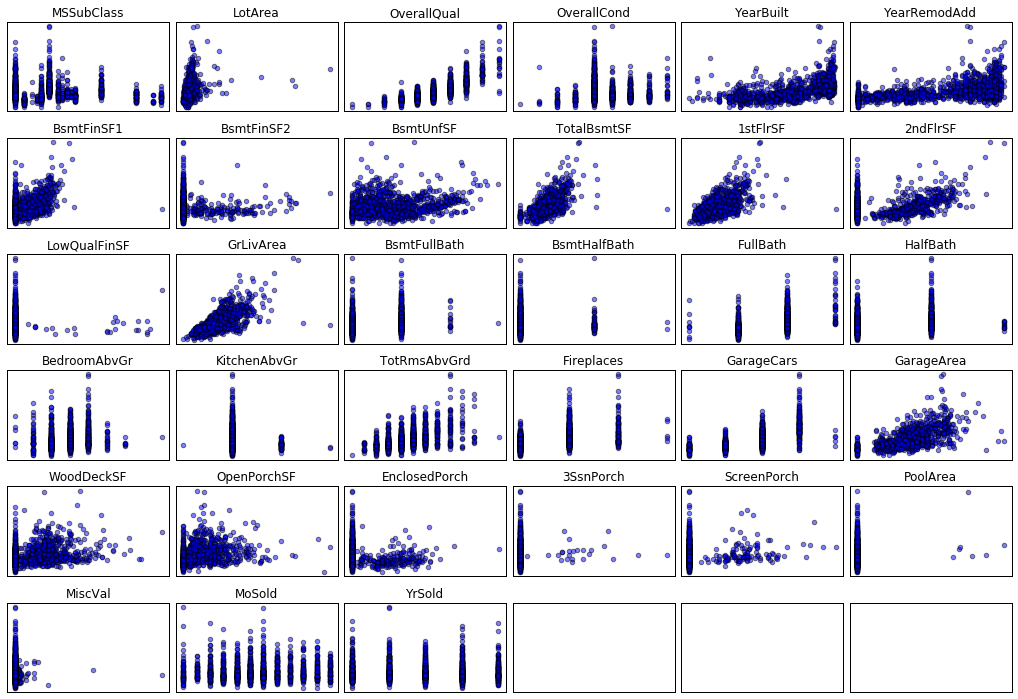

In [98]:
f, axarr = plt.subplots(6,6, figsize=(18,12))
plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.04 )
counter = 0
for i in range(6):
    for j in range(6):
        axarr[i][j].get_yaxis().set_ticks([])
        axarr[i][j].get_xaxis().set_ticks([])
        if counter >= numericals.shape[1]-1:
            continue
        else:
            axarr[i][j].scatter(x_normed[:,counter], y,alpha=0.5)
            axarr[i][j].set_title(numericals.columns[counter])
            counter += 1